In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [81]:
% cd /content/drive/'My Drive'/Internship2
!ls

/content/drive/My Drive/Internship2
 classes		      'Loading in our own data.ipynb'   y_train.pickle
 CNN.ipynb		      'Random Forest.ipynb'	        y_val.pickle
 CNN-Transfer_Learning.ipynb   X_train.pickle
 furniture_classifier.hd5      X_val.pickle


In [0]:
from pathlib import Path
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
from keras.applications.resnet50 import ResNet50, preprocess_input

### create a datagen for training

In [0]:
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "classes/train"
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), batch_size=BATCH_SIZE)

Found 1695 images belonging to 4 classes.


In [0]:
train_steps = 1695//BATCH_SIZE

### create a datagen for testing

In [0]:
VALID_DIR = "classes/val"
valid_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
#       rotation_range=90,
      horizontal_flip=True
#       vertical_flip=True
    )

valid_generator = valid_datagen.flow_from_directory(VALID_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
batch_size=BATCH_SIZE)

Found 92 images belonging to 4 classes.


In [0]:
valid_steps = 92//BATCH_SIZE

### create the network

In [0]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    # freeze the layers of the base model. We don't want to change the base feature extraction part
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    
    # we add our own classification part on top of the base model which is a combination of dense and dropout
    # followed by a softmax
    # the dense + dropout will add our own feature extraction which we can fine tune and classify
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [0]:
class_list = ['bed', 'chair', 'sofa', 'table']

In [0]:
FC_LAYERS = [1024, 1024]
dropout = 0.5

HEIGHT = 300
WIDTH = 300

# we use resnet50 as the base model without the top (means it doesn't have a FC + softmax/classifier on top)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, num_classes=len(class_list))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Choose optimizer

In [0]:
!ls

 classes		       img.rar			        X_val.pickle
 CNN.ipynb		       img.zip			        y_train.pickle
 CNN-Transfer_Learning.ipynb  'Loading in our own data.ipynb'   y_val.pickle
 furniture_classifier.hd5     'Random Forest.ipynb'
 img2.zip		       X_train.pickle


In [0]:
from keras.optimizers import SGD, Adam


BATCH_SIZE = 8
num_train_images = 500

adam = Adam(lr=0.0001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

### train the network

In [0]:
NUM_EPOCHS = 15

In [0]:
history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=train_steps, 
                                       validation_data=valid_generator, validation_steps=valid_steps,
                                       shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/15
211/211 [==============================] - 106s 503ms/step - loss: 3.3206 - acc: 0.7209 - val_loss: 0.2355 - val_acc: 0.9659
Epoch 2/15
211/211 [==============================] - 83s 391ms/step - loss: 1.7465 - acc: 0.8571 - val_loss: 0.1979 - val_acc: 0.9881
Epoch 3/15
211/211 [==============================] - 83s 392ms/step - loss: 1.1836 - acc: 0.9080 - val_loss: 1.5439 - val_acc: 0.8690
Epoch 4/15
211/211 [==============================] - 82s 391ms/step - loss: 1.1390 - acc: 0.9122 - val_loss: 0.2297 - val_acc: 0.9762
Epoch 5/15
211/211 [==============================] - 82s 391ms/step - loss: 0.9566 - acc: 0.9230 - val_loss: 1.4261 - val_acc: 0.9048
Epoch 6/15
211/211 [==============================] - 82s 391ms/step - loss: 0.9651 - acc: 0.9300 - val_loss: 0.3672 - val_acc: 0.9286
Epoch 7/15
211/211 [==============================] - 83s 392ms/step - loss: 0.7651 - acc: 0.93

In [0]:
finetune_model.save_weights('furniture_classifier.hd5')

In [0]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

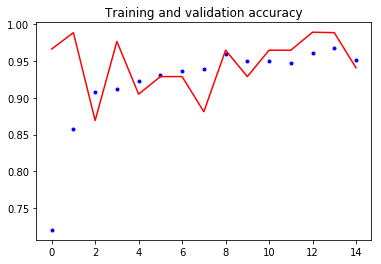

In [0]:
plot_training(history)

In [0]:
# test on our internal test set
TEST_BATCH_SIZE = 8
TEST_DIR = "classes/val"
test_datagen =  ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = train_datagen.flow_from_directory(TEST_DIR, 
                                                   target_size=(HEIGHT, WIDTH), batch_size=TEST_BATCH_SIZE,class_mode='categorical',shuffle=False)

Found 92 images belonging to 4 classes.


In [0]:
# finetune_model.load_weights("furniture_classifier.hd5")
losses = finetune_model.evaluate_generator(test_generator)
losses

[0.8459189197291616, 0.9456521739130435]

### Confusion Matrix

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 0 3 0 0 3 3 3 3 3 3]


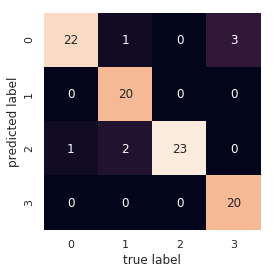

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
Y_pred = finetune_model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
mat = confusion_matrix(test_generator.classes, y_pred)
print(test_generator.classes)
print(y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');




(array([26.,  0.,  0., 20.,  0.,  0., 26.,  0.,  0., 20.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

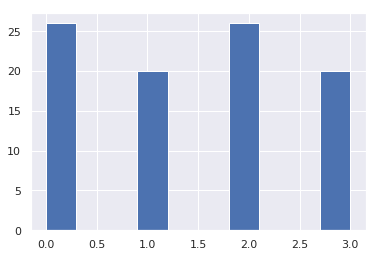

In [0]:
plt.hist(y_pred, bins=10, range=None, normed=None, weights=None, density=None)